# NTDS'18 milestone 1: network collection and properties
[Effrosyni Simou](https://lts4.epfl.ch/simou), [EPFL LTS4](https://lts4.epfl.ch)

## Rules

* Milestones have to be completed by teams. No collaboration between teams is allowed.
* Textual answers shall be short. Typically one to three sentences.
* Code has to be clean.
* You cannot import any other library than we imported.
* When submitting, the notebook is executed and the results are stored. I.e., if you open the notebook again it should show numerical results and plots. We won't be able to execute your notebooks.
* The notebook is re-executed from a blank state before submission. That is to be sure it is reproducible. You can click "Kernel" then "Restart & Run All" in Jupyter.

## Objective 

The purpose of this milestone is to start getting acquainted to the network that you will use for this class. In the first part of the milestone you will import your data using [Pandas](http://pandas.pydata.org) and you will create the adjacency matrix using [Numpy](http://www.numpy.org). This part is project specific. In the second part you will have to compute some basic properties of your network. **For the computation of the properties you are only allowed to use the packages that have been imported in the cell below.** You are not allowed to use any graph-specific toolboxes for this milestone (such as networkx and PyGSP). Furthermore, the aim is not to blindly compute the network properties, but to also start to think about what kind of network you will be working with this semester. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Part 1 - Import your data and manipulate them. 

In [2]:
adjacency = pd.read_csv('Different Adjacency/CoAppearance-bechdel/CoAppAdjacency.csv', index_col=0)
adjacency = pd.DataFrame(adjacency)

In [3]:
non_connected = list(adjacency.columns[adjacency.sum() == 0])
adjacency = adjacency.drop(columns=non_connected)
non_connected_rows = [int(x) for x in non_connected]
adjacency = adjacency.drop(non_connected_rows, axis=0)

In [4]:
n_nodes = len(adjacency)

In [27]:
n_nodes

2178

In [5]:
edges = pd.read_csv('Different Adjacency/CoAppearance-bechdel/CoAppBechdelEdges.csv', index_col=0)

## Part 2

Execute the cell below to plot the (weighted) adjacency matrix of your network.

Text(0.5, 1.05, 'adjacency matrix')

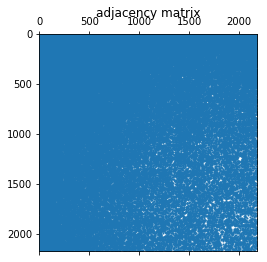

In [6]:
plt.spy(adjacency, markersize=1)
plt.title('adjacency matrix')

### Question 1

What is the maximum number of links $L_{max}$ in a network with $N$ nodes (where $N$ is the number of nodes in your network)? How many links $L$ are there in your collected network? Comment on the sparsity of your network.

In [7]:
# Our graph is directed therefore :
Lmax = n_nodes * (n_nodes - 1)
print("Maximum number of links in our network : {}".format(Lmax))
links = np.count_nonzero(adjacency)
print("Number of links in our network : {}".format(links))
sparsity = links * 100 / Lmax
print("The sparsity of our network is : {:.4f}%".format(sparsity))

Maximum number of links in our network : 4741506
Number of links in our network : 95686
The sparsity of our network is : 2.0181%


The maximum number of links $L_{max}$ in an network with $N$ nodes is $L_{maxUndirected}=\binom{N}{2}=\frac{N(N-1)}{2}$ and $L_{maxDirected}=N(N-1)$.

We can see that our network is very sparse which makes sense as we work on a flights routes dataset. Thus, small airports have few connections compared to the big ones.

### Question 2

Is your graph directed or undirected? If it is directed, convert it to an undirected graph by symmetrizing the adjacency matrix.

Our graph is directed. (Some airports don't have the same number of incoming and outgoing flights.)

In [8]:
# We symmetrize our network by summing our weights (the number of incoming and outgoing flights)
# since it allows us to keep the maximum number of information.
adjacency_sym = adjacency.values

### Question 4

Are the edges of your graph weighted?

Yes, the weights of the symmetrized adjacency matrix are the total number of outgoing and incoming flights from each node.

### Question 5

What is the degree distibution of your network? 

In [10]:
# The degree of a node is the sum of its corresponding row or column in the adjacency matrix.
degree = np.count_nonzero(adjacency, axis=1)

assert len(degree) == n_nodes

Execute the cell below to see the histogram of the degree distribution.

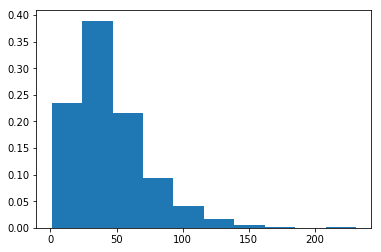

In [11]:
weights = np.ones_like(degree) / float(n_nodes)
plt.hist(degree, weights=weights);

What is the average degree?

In [12]:
avg_deg = np.mean(degree)
print("The average degree is {:.4f}".format(avg_deg))

The average degree is 43.9330


### Question 6

Comment on the degree distribution of your network.

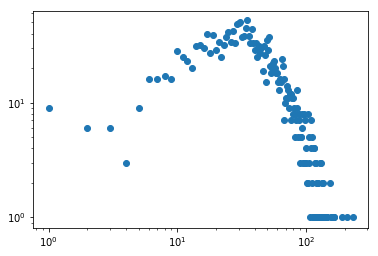

In [13]:
test = np.unique(degree,return_counts=True)
ax = plt.gca()
ax.scatter(test[0],test[1])
ax.set_yscale("log")
ax.set_xscale("log")

Our degree distribution follows a power law distribution, hence our network seems to be scale free as we saw in the lecture.

### Question 7

Write a function that takes as input the adjacency matrix of a graph and determines whether the graph is connected or not.

In [14]:
def BFS(adjacency, labels, state):
    """
    return a component with an array of updated labels (the visited nodes during the BFS)
    for a given adjacency matrix
    
    :param adjacency: The adjacency matrix where to find the component
    :param labels: An array of labels (0 : the node is not yet explored, 1: it is explored)
    :param state: The # of the component we are looking for
    :return: updated labels array and the component found
    """
    queue = []
    # current node is the first one with a label to 0
    current_node = np.argwhere(labels == 0).flatten()[0]
    labels[current_node] = state
    queue.append(current_node)

    current_component = []
    current_component.append(current_node)
    
    while len(queue) != 0:
        # all the weight of the other nodes for a given one
        all_nodes = adjacency_sym[current_node]
        # all the nodes reachable from the current one that are not yet labeled
        neighbours = np.argwhere((all_nodes > 0) & (labels == 0)).flatten()
        # add those nodes to the queue and to the component
        queue += list(neighbours)
        current_component += list(neighbours)
        
        for i in neighbours:
            # we update the labels array
            labels[i] = state
        if len(queue) > 1:
            # and we update the queue and the current node
            queue = queue[1:]
            current_node = queue[0]
        else :
            queue = []
    
    return np.array(labels), current_component    

In [15]:
def connected_graph(adjacency):
    """Determines whether a graph is connected.
    
    Parameters
    ----------
    adjacency: numpy array
        The (weighted) adjacency matrix of a graph.
    
    Returns
    -------
    bool
        True if the graph is connected, False otherwise.
    """
    #Run the BFS, find a component and see if all the nodes are in it. If so, the graph is connected.
    first_labels = np.zeros(n_nodes, dtype=int)
    labels, component = BFS(adjacency, first_labels, 1)
    return labels.sum() == n_nodes

Is your graph connected? Run the ``connected_graph`` function to determine your answer.

In [16]:
connected = connected_graph(adjacency)
print("Is our graph connected ? {}".format(connected))

Is our graph connected ? True


### Question 8

Write a function that extracts the connected components of a graph.

In [17]:
def find_components(adjacency):
    """Find the connected components of a graph.
    
    Parameters
    ----------
    adjacency: numpy array
        The (weighted) adjacency matrix of a graph.
    
    Returns
    -------
    list of numpy arrays
        A list of adjacency matrices, one per connected component.
    """
    
    #Find the first component
    components = []
    first_labels = np.zeros(n_nodes, dtype=int)
    labels, component = BFS(adjacency, first_labels, 1)
    components.append(component)
    current_state = 2
    
    #Redo BFS while we haven't found all the components
    while (labels > 0).sum() != n_nodes:
        labels, component = BFS(adjacency, labels, current_state)
        components.append(component)
        current_state += 1
        
    return np.array(components)

How many connected components is your network composed of? What is the size of the largest connected component? Run the ``find_components`` function to determine your answer. 

In [18]:
components = find_components(adjacency_sym)
print("Number of connected components : {}".format(len(components)))
size_compo = [len(compo) for compo in components]
print("Size of largest connected component : {}".format(np.max(size_compo)))

Number of connected components : 1
Size of largest connected component : 2178


### Question 9

Write a function that takes as input the adjacency matrix and a node (`source`) and returns the length of the shortest path between that node and all nodes in the graph using Dijkstra's algorithm. **For the purposes of this assignment we are interested in the hop distance between nodes, not in the sum of weights. **

Hint: You might want to mask the adjacency matrix in the function ``compute_shortest_path_lengths`` in order to make sure you obtain a binary adjacency matrix. 

In [19]:
#Find all the neighbours of a given node
def neighbours(node, adjacency_sym):
    n = adjacency_sym[node]
    neighbours = np.argwhere(n != 0).flatten()
    return neighbours

In [20]:
def compute_shortest_path_lengths(adjacency, source):
    """Compute the shortest path length between a source node and all nodes.
    
    Parameters
    ----------
    adjacency: numpy array
        The (weighted) adjacency matrix of a graph.
    source: int
        The source node. A number between 0 and n_nodes-1.
    
    Returns
    -------
    list of ints
        The length of the shortest path from source to all nodes. Returned list should be of length n_nodes.
    """   
    
    adjacency[adjacency != 0] = 1
    shortest_path_lengths = np.ones(adjacency.shape[0]) * np.inf
    shortest_path_lengths[source] = 0
    visited = [source]
    queue = [source]
    while queue:
        node = queue[0]
        queue = queue[1:]
        neighbors = neighbours(node, adjacency)
        neighbors = np.setdiff1d(neighbors,visited).tolist()
        neighbors = np.setdiff1d(neighbors,queue).tolist()
        queue += neighbors
        visited += neighbors
        shortest_path_lengths[neighbors] = shortest_path_lengths[node] + 1
    return shortest_path_lengths

### Question 10

The diameter of the graph is the length of the longest shortest path between any pair of nodes. Use the above developed function to compute the diameter of the graph (or the diameter of the largest connected component of the graph if the graph is not connected). If your graph (or largest connected component) is very large, computing the diameter will take very long. In that case downsample your graph so that it has 1.000 nodes. There are many ways to reduce the size of a graph. For the purposes of this milestone you can chose to randomly select 1.000 nodes. 

In [21]:
max_component = components[np.argmax(size_compo)]
adjacency_max = adjacency_sym[max_component, :]
adjacency_max = adjacency_max[:, max_component]

longest = []
a = adjacency_max[:1000,:1000]

for node in range(len(a)):
    short = compute_shortest_path_lengths(a, node)
    longest.append(max(short[ short < np.inf ]))
    
print("The diameter of the graph is {}".format(max(longest)))

The diameter of the graph is 4.0


### Question 11

Write a function that takes as input the adjacency matrix, a path length, and two nodes (`source` and `target`), and returns the number of paths of the given length between them.

In [22]:
def compute_paths(adjacency, source, target, length):
    """Compute the number of paths of a given length between a source and target node.
    
    Parameters
    ----------
    adjacency: numpy array
        The (weighted) adjacency matrix of a graph.
    source: int
        The source node. A number between 0 and n_nodes-1.
    target: int
        The target node. A number between 0 and n_nodes-1.
    length: int
        The path length to be considered.
    
    Returns
    -------
    int
        The number of paths.
    """
    
    adjacency[adjacency != 0] = 1
    adjacency = np.linalg.matrix_power(adjacency, length)
    return adjacency[source, target]

Test your function on 5 pairs of nodes, with different lengths.

In [23]:
print(compute_paths(adjacency_sym, 0, 10, 1))
print(compute_paths(adjacency_sym, 0, 10, 2))
print(compute_paths(adjacency_sym, 0, 10, 3))
print(compute_paths(adjacency_sym, 23, 67, 2))
print(compute_paths(adjacency_sym, 15, 93, 4))

1.0
24.0
1671.0
2.0
16265.0


### Question 12

How many paths of length 3 are there in your graph? Hint: calling the `compute_paths` function on every pair of node is not an efficient way to do it.

In [24]:
# We could have used np.linalg.matrix_power(a, 3), but for performance reasons we prefered to make 
#the multiplication explicitely.
a = adjacency_sym.copy()
a[a != 0] = 1
a = a @ a @ a
print("Number of path of length 3: {}".format(a.sum()))

Number of path of length 3: 372522032.0


### Question 13

Write a function that takes as input the adjacency matrix of your graph (or of the largest connected component of your graph) and a node and returns the clustering coefficient of that node. 

In [25]:
def compute_clustering_coefficient(adjacency, node):
    """Compute the clustering coefficient of a node.
    
    Parameters
    ----------
    adjacency: numpy array
        The (weighted) adjacency matrix of a graph.
    node: int
        The node whose clustering coefficient will be computed. A number between 0 and n_nodes-1.
    
    Returns
    -------
    float
        The clustering coefficient of the node. A number between 0 and 1.
    """
    
    adjacency[adjacency >1]=1
    neighbors = adjacency[node]
    indices = np.argwhere(neighbors > 0).flatten()
    
    if len(indices) <2:
        return 0
    
    #Take the neighbors of the neighbors, and find wich one are linked together
    neiofnei = adjacency[indices]
    test = neiofnei * neighbors
    count =  sum(test.flatten())
    #Compute the clustering coefficient for the node. Since each link is counted twice, we don't multiply the formula by 2.
    clustering_coefficient = count / (len(indices)*(len(indices)-1))    
    
    return clustering_coefficient

### Question 14

What is the average clustering coefficient of your graph (or of the largest connected component of your graph if your graph is disconnected)? Use the function ``compute_clustering_coefficient`` to determine your answer.

In [26]:
adjacency_component = adjacency_sym[components[0]]
adjacency_component = adjacency_component.T[components[0]].T
N = len(components[0])
count = 0
for i in range(N):
    count+=compute_clustering_coefficient(adjacency_component,i)

avg_coeff = count/N

print("The average coefficient of our largest connected component is : {}".format(str(avg_coeff)))

The average coefficient of our largest connected component is : 0.3683419503232065
